In [1]:
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_

from tqdm.notebook import tqdm

In [2]:
class MnistDataset(Dataset):
    def __init__(self, img_gzip, label_gzip, base_dir):
        self.img_gzip_path = base_dir + img_gzip
        self.label_gzip_path = base_dir + label_gzip
        self.imgs, self.labels = None, None
        self.load()

    def load(self):
        with open(self.img_gzip_path,'rb') as f:
            magic, size = struct.unpack(">II", f.read(8))
            nrows, ncols = struct.unpack(">II", f.read(8))
            self.imgs = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))\
                     .reshape((size, nrows, ncols, 1))
            self.imgs = np.transpose(self.imgs, (0,3,1,2))

        with open(self.label_gzip_path,'rb') as f:
            magic, size = struct.unpack('>II', f.read(8))
            self.labels = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, idx):
        img = torch.tensor(self.imgs[idx], dtype=torch.float32)/127.5 - 1
        label = torch.tensor(self.labels[idx])
        return img, label

In [3]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cuda") if torch.cuda.is_available() else device

In [4]:
base_dir = 'data/mnist/'
img_gzip = "train-images.idx3-ubyte"
label_gzip = "train-labels.idx1-ubyte"

batch_size = 32

dataset = MnistDataset(img_gzip = img_gzip,
                       label_gzip = label_gzip,
                       base_dir = base_dir)

dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

In [5]:
import torch
import torch.nn as nn

class PredictNoise(nn.Module):
    def __init__(self, in_channel = 3, hidden_channel = 256, out_channel = 3, kernel_size = 3, device = 'cpu'):
        super().__init__()
        self.device = device
        self.time_dim = 128
        self.hidden_channel = hidden_channel

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channel, hidden_channel, kernel_size),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_channel, hidden_channel, kernel_size),
            nn.LeakyReLU(),
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_channel, hidden_channel, kernel_size),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_channel, hidden_channel, kernel_size),
            nn.LeakyReLU(),
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(hidden_channel, hidden_channel, kernel_size),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(hidden_channel, hidden_channel, kernel_size),
            nn.LeakyReLU(),
        )

        self.block_4 = nn.Sequential(
            nn.ConvTranspose2d(2*hidden_channel, hidden_channel, kernel_size),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(hidden_channel, hidden_channel, kernel_size),
            nn.LeakyReLU(),
        )

        self.block_5 = nn.Sequential(
            nn.ConvTranspose2d(2*hidden_channel, hidden_channel, kernel_size),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(hidden_channel, out_channel, kernel_size),
            nn.LeakyReLU(),
        )

        self.last_conv = nn.Conv2d(2*out_channel, out_channel, kernel_size,  padding = "same")
        self.embedding_layer = nn.Linear(self.time_dim, hidden_channel)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def encode_t(self, x, t, dims):
        t = self.embedding_layer(t).unsqueeze(2).unsqueeze(3)
        t = t.expand(x.shape[0], dims, x.shape[2], x.shape[3])
        return t

    def forward(self, x, t):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.block_1(x)

        x2 = x1 + self.encode_t(x1, t, dims = self.hidden_channel)
        x2 = self.block_2(x2)

        x3 = x2 + self.encode_t(x2, t, dims = self.hidden_channel)
        x3 = self.block_3(x3)

        x4 = self.block_4(torch.cat((x3, x2), axis = 1))
        x5 = self.block_5(torch.cat((x4, x1), axis = 1))
        out = self.last_conv(torch.cat((x5, x), axis = 1))

        return out

In [6]:
model = PredictNoise(in_channel = 1, out_channel = 1, device = device).to(device)
beta = 5e-3
T = 1000
alpha = 1 - beta

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)

In [7]:
beta_start, beta_end = (1e-4, 0.02)
beta = torch.linspace(beta_start, beta_end, T, device = device)
alpha = 1 - beta
alpha_hat = torch.cumprod(alpha, dim = 0)

In [8]:
epochs = 10
history = {'loss':[]}
model.train()
for epoch in tqdm(range(epochs)):
    loss_ = []
    for idx, (x_batch, y_batch) in tqdm(enumerate(dataloader), total = len(dataloader), desc = f"{epoch}"):
        x_batch = x_batch.to(device)
        t_batch = torch.randint(T, size=(batch_size,), device = device)
        eps_batch = torch.tensor(np.random.normal(size=x_batch.shape),
                                 dtype=torch.float32,
                                 device = device)

        alpha_batch = alpha_hat[t_batch].reshape(batch_size, x_batch.shape[1])
        alpha_batch = alpha_batch.unsqueeze(2).unsqueeze(3).expand(batch_size, 1, 28, 28)
        x_batch = torch.sqrt(alpha_batch)*x_batch + torch.sqrt(1-alpha_batch)*eps_batch

        pred_eps = model(x_batch, t_batch)
        loss = loss_fn(pred_eps, eps_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    loss_ = np.mean(loss_)
    history['loss'].append(loss_)
    print(f"[{epoch+1}] Loss : {loss_:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

0:   0%|          | 0/1875 [00:00<?, ?it/s]

[1] Loss : 0.1706


1:   0%|          | 0/1875 [00:00<?, ?it/s]

[2] Loss : 0.0667


2:   0%|          | 0/1875 [00:00<?, ?it/s]

[3] Loss : 0.0417


3:   0%|          | 0/1875 [00:00<?, ?it/s]

[4] Loss : 0.0349


4:   0%|          | 0/1875 [00:00<?, ?it/s]

[5] Loss : 0.0321


5:   0%|          | 0/1875 [00:00<?, ?it/s]

[6] Loss : 0.0304


6:   0%|          | 0/1875 [00:00<?, ?it/s]

[7] Loss : 0.0287


7:   0%|          | 0/1875 [00:00<?, ?it/s]

[8] Loss : 0.0281


8:   0%|          | 0/1875 [00:00<?, ?it/s]

[9] Loss : 0.0278


9:   0%|          | 0/1875 [00:00<?, ?it/s]

[10] Loss : 0.0270


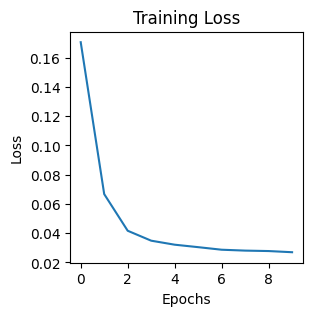

In [9]:
fig = plt.figure(figsize=(3,3))
fig = plt.plot(history['loss'])
_ = plt.gca().set(xlabel='Epochs', ylabel='Loss', title='Training Loss')

In [10]:
samples = 32
model.eval()
with torch.no_grad():
    x_sample = torch.tensor(np.random.normal(size=(samples, 1, 28, 28)),
                                     dtype=torch.float32,
                                     device = device)
    for t in tqdm(range(T-1, 0, -1)):
        z = torch.tensor(np.random.normal(size=(samples, 1, 28, 28)),
                                     dtype=torch.float32,
                                     device = device)

        if t == 0 : z = 0
        time_step = t
        t = torch.tensor(t, device = device).unsqueeze(0).expand(samples)
        alpha_batch = alpha_hat[t].reshape(samples, 1)
        alpha_batch = alpha_batch.unsqueeze(2).unsqueeze(3).expand(samples, 1, 28, 28)
        noise_pred = model(x_sample, t)
        x_sample = 1/torch.sqrt(alpha[time_step]) * (x_sample - ((1-alpha[time_step])/torch.sqrt(1-alpha_batch))*noise_pred)
        x_sample = x_sample + torch.sqrt(beta[time_step]) * z
    x_sample = x_sample.clamp(-1,1).cpu().numpy()
    x_sample = np.transpose(x_sample, (0, 2, 3, 1))

  0%|          | 0/999 [00:00<?, ?it/s]

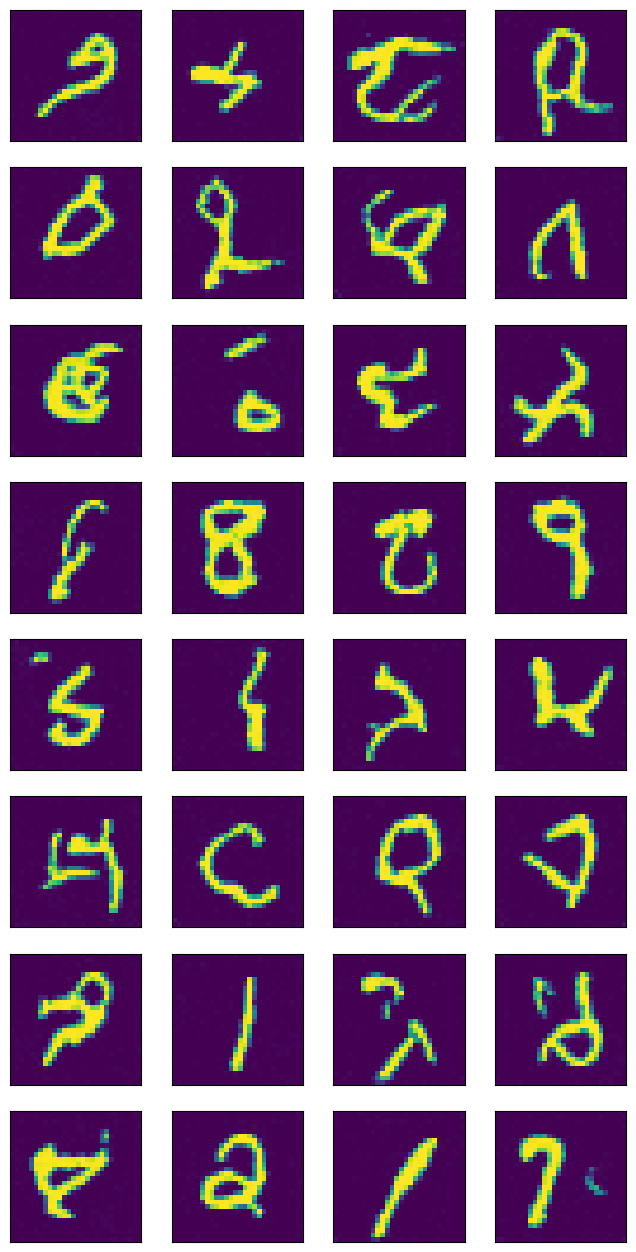

In [11]:
num_rows, num_cols = 8, 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8,16))
for row in range(num_rows):
    for col in range(num_cols):
        axs[row][col].imshow((x_sample[row*num_cols + col]+1)/2)
        axs[row][col].set(xticks=[], yticks=[])